In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# parameters
mu, sigma = 2.0, 1.0
data_range = 5

input_size = 1
z_size = 1
hidden_size = 16
smooth = 0.1

learning_rate = 0.03
n_epochs_pre = 1000
n_epochs = 3000
M = 150 # batch size

# dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [3]:
# from: https://github.com/torch/TH/pull/4/commits/0bf1bbf3975a752675677a03b73b8b485640e3c5
def truncated_normal(size, mean=0.0, stddev=1.0):
    a, b = 0.0, (1.0 - np.exp(-2.0))
    x = np.random.rand(size)
    y = (np.random.rand(size) * (b - a)) + a
    rho = np.sqrt(-2.0 * np.log(1.0 - y))
    ret = rho * np.cos(2.0 * np.pi * x) * stddev + mean
    return ret.astype(np.float32)

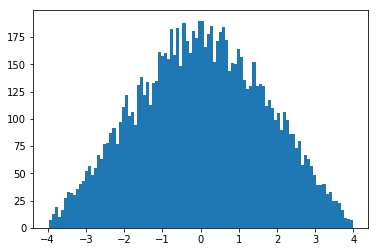

In [4]:
test_tn_samples = truncated_normal(10000, stddev=2.0)
plt.hist(test_tn_samples, bins=100)
plt.show()

In [5]:
class DataDistribution(object):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def sample(self, N):
        return np.random.normal(self.mu, self.sigma, N)

In [6]:
class GeneratorDistribution(object):
    def __init__(self, range):
        self.range = range

    def sample(self, N):
        return np.linspace(-self.range, self.range, N) + np.random.random(N) * 0.01

In [7]:
# weight initialization: https://discuss.pytorch.org/t/weight-initilzation/157
def weight_init(m, stddev=2.0):
    classname = m.__class__.__name__
    if isinstance(m, torch.nn.Linear):
        # set weights
        size_0 = m.weight.data.size()[0]
        size_1 = m.weight.data.size()[1]
        w_np = truncated_normal(size_0 * size_1, stddev=stddev)
        w_np = np.reshape(w_np, [size_0, size_1])
        m.weight.data = torch.from_numpy(w_np)
        
        # set bias
        m.bias.data.fill_(0)

In [8]:
class Generator(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # fully connected layers
        self.layer1 = torch.nn.Linear(input_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, output_size)        
        
        # initialize weight with truncated normal
        for m in self.modules():
            weight_init(m, stddev=2.0)

    def forward(self, x):
        layer = torch.nn.functional.leaky_relu(self.layer1(x))
        return self.layer2(layer)

In [9]:
class Discriminator(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # fully connected layers
        self.layer1 = torch.nn.Linear(input_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, output_size)        
        
        # initialize weight with truncated normal(variance scaling)
        stddev = np.sqrt(1.3 * 2.0 / 1.0)
        #stddev = 2
        for m in self.modules():
            weight_init(m, stddev)
        
    def forward(self, x):
        layer = torch.nn.functional.leaky_relu(self.layer1(x))
        return torch.nn.functional.sigmoid(self.layer2(layer))

In [10]:
def test_samples(D, G, d_data, g_data, sample_range, batch_size, num_points=10000, num_bins=100):
    # 1. decision boundary
    xs = np.linspace(-sample_range, sample_range, num_points)
    db = np.zeros((num_points, 1))
    for i in range(num_points // batch_size):
        curr_loc = batch_size * i
        next_loc = batch_size * (i + 1)
        x_ = xs[curr_loc:next_loc]
        x_ = torch.Tensor(np.reshape(x_, [batch_size, 1]))
        x_ = torch.autograd.Variable(x_)
        
        db[curr_loc:next_loc] = D(x_).data.numpy()

    # data distribution
    bins = np.linspace(-sample_range, sample_range, num_bins)
    d = d_data.sample(num_points)
    pd, _ = np.histogram(d, bins=bins, density=True)
    
    if G is not None:
        # generated samples
        zs = g_data.sample(num_points)
        g = np.zeros((num_points, 1))
        for i in range(num_points // batch_size):
            curr_loc = batch_size * i
            next_loc = batch_size * (i + 1)

            z_ = zs[curr_loc:next_loc]
            z_ = torch.Tensor(np.reshape(z_, [batch_size, 1]))
            z_ = torch.autograd.Variable(z_)
            g_raw_out = G(z_).data.numpy()
            g[curr_loc:next_loc] = g_raw_out * sample_range
        pg, _ = np.histogram(g, bins=bins, density=True)
    else:
        pg = None
    
    return db, pd, pg

In [11]:
def plot_distributions(samps, sample_range, title='1D Generative Adversarial Network'):
    db, pd, pg = samps
    db_x = np.linspace(-sample_range, sample_range, len(db))
    p_x = np.linspace(-sample_range, sample_range, len(pd))
    f, ax = plt.subplots(1)
    ax.plot(db_x, db, label='decision boundary')
    ax.set_ylim(0, 1)
    ax.set_xlim(-sample_range, sample_range)
    plt.plot(p_x, pd, label='real data')
    if pg is not None:
        plt.plot(p_x, pg, label='generated data')
    plt.title(title)
    plt.xlabel('Data values')
    plt.ylabel('Probability density')
    plt.legend()
    plt.show()

# Prepare data distributions

In [12]:
data = DataDistribution(mu, sigma)
gen = GeneratorDistribution(data_range)

# Prepare Models

In [13]:
G = Generator(input_size=z_size, hidden_size=hidden_size, output_size=1)
D = Discriminator(input_size=input_size, hidden_size=hidden_size, output_size=1)

# coefficients used for computing running averages 
# of gradient and its square (default: (0.9, 0.999))
# optim_betas = (0.9, 0.999)
# d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=optim_betas)
# g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=optim_betas)

#d_optimizer = torch.optim.SGD(D.parameters(), lr=learning_rate)
#g_optimizer = torch.optim.SGD(G.parameters(), lr=learning_rate)

# Binary cross entropy
criterion = torch.nn.BCELoss()

# Pre-training session

In [14]:
pre_losses = []
for e in range(n_epochs_pre):    
    N = 1000
    d = data.sample(N)
    n_bins = 100
    histc, edges = np.histogram(d, bins=n_bins, density=True)

    # Estimated pdf is used as labels after normalization
    max_histc = np.max(histc)
    min_histc = np.min(histc)
    y_ = (histc - min_histc) / (max_histc - min_histc)
    x_ = edges[1:]

    x_ = torch.Tensor(np.reshape(x_, [n_bins, input_size]))
    y_ = torch.Tensor(np.reshape(y_, [n_bins, input_size]))
    x_ = torch.autograd.Variable(x_)
    y_ = torch.autograd.Variable(y_)
    
    d_pre_decision = D(x_)
    d_pre_loss = criterion(d_pre_decision, y_)
    
    '''
    Before the backward pass, use the optimizer object to zero all of the
    gradients for the variables it will update (which are the learnable weights
    of the model)
    '''
    D.zero_grad()
    d_pre_loss.backward()
    #pre_optimizer.step()
    
    # update weights with graident descent
    #for param in Pre_trainer.parameters():
    for param in D.parameters():
        param.data -= learning_rate * param.grad.data
    
    # Save losses to view after training
    pre_losses.append(d_pre_loss[0].data.numpy())
    
    # at last step
    if e == n_epochs_pre-1:
        #samps = test_samples(Pre_trainer, None, data, gen, data_range, M)
        samps = test_samples(D, None, data, gen, data_range, M)

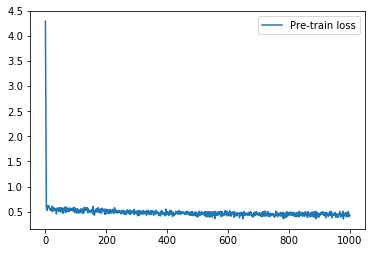

In [15]:
fig, ax = plt.subplots()
pre_losses = np.array(pre_losses)
plt.plot(pre_losses, label='Pre-train loss')
plt.legend()

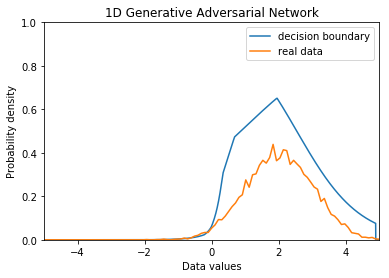

In [16]:
plot_distributions(samps, data_range)

# Actual training

In [17]:
d_losses = []
g_losses = []
for e in range(n_epochs):
    # 1. Train D on real+fake    
    # 1A: Train D on real
    x_ = data.sample(M)
    x_ = torch.Tensor(np.reshape(x_, [M, input_size]))
    y_real_ = torch.ones([M, input_size]) * (1 - smooth)
    y_fake_ = torch.zeros([M, input_size])
    
    x_ = torch.autograd.Variable(x_)
    y_real_ = torch.autograd.Variable(y_real_)
    y_fake_ = torch.autograd.Variable(y_fake_)
    
    d_real_decision = D(x_)
    d_real_loss = criterion(d_real_decision, y_real_)
    
    #  1B: Train D on fake
    z1_ = gen.sample(M)
    z1_ = torch.Tensor(np.reshape(z1_, [M, z_size]))
    
    z1_ = torch.autograd.Variable(z1_)
    d_fake_data = G(z1_)
    
    d_fake_decision = D(d_fake_data)
    d_fake_loss = criterion(d_fake_decision, y_fake_)
    d_loss = d_real_loss + d_fake_loss
    
    '''
    Before the backward pass, use the optimizer object to zero all of the
    gradients for the variables it will update (which are the learnable weights
    of the model)
    '''
    D.zero_grad()
    d_loss.backward()
    #d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()
    # update weights with graident descent
    for param in D.parameters():
        param.data -= learning_rate * param.grad.data
    
    
    # 2. Train G on D's response (but DO NOT train D on these labels)    
    # z2_ = gen.sample(M)
    # z2_ = torch.Tensor(np.reshape(z2_, [M, z_size]))
    y_ = torch.ones([M, z_size])
    
    # z2_ = torch.autograd.Variable(z2_)
    y_ = torch.autograd.Variable(y_)
    
    g_fake_data = G(z1_)
    dg_fake_decision = D(g_fake_data)
    g_loss = criterion(dg_fake_decision, y_)
    
    
    '''
    Before the backward pass, use the optimizer object to zero all of the
    gradients for the variables it will update (which are the learnable weights
    of the model)
    '''
    G.zero_grad()
    g_loss.backward()
    #g_optimizer.step()
    # update weights with graident descent
    for param in G.parameters():
        param.data -= learning_rate * param.grad.data
    
    # Save losses to view after training
    d_losses.append(d_loss[0].data.numpy())
    g_losses.append(g_loss[0].data.numpy())
        
    if e % 100 == 0:
        print('{}: D: {} G: {}'.format(e, d_loss[0].data.numpy(), g_loss[0].data.numpy()))
    
    if e == n_epochs-1:
        samps = test_samples(D, G, data, gen, data_range, M)

0: D: [ 0.82871395] G: [ 23.13459015]
100: D: [ 1.74860811] G: [ 3.37263298]
200: D: [ 1.52677369] G: [ 0.58628219]
300: D: [ 1.43490887] G: [ 0.63241422]
400: D: [ 1.40403867] G: [ 0.97420448]
500: D: [ 1.3842802] G: [ 0.76970571]
600: D: [ 1.37706017] G: [ 0.84450233]
700: D: [ 1.37972534] G: [ 0.82875204]
800: D: [ 1.38554668] G: [ 0.88499421]
900: D: [ 1.37465346] G: [ 0.77212548]
1000: D: [ 1.36839938] G: [ 0.71881503]
1100: D: [ 1.42805624] G: [ 1.01849258]
1200: D: [ 1.38016951] G: [ 0.87377667]
1300: D: [ 1.37675977] G: [ 0.88797718]
1400: D: [ 1.37468398] G: [ 0.72381955]
1500: D: [ 1.37884831] G: [ 0.84020299]
1600: D: [ 1.37643933] G: [ 0.80542421]
1700: D: [ 1.38116121] G: [ 0.86476296]
1800: D: [ 1.3756907] G: [ 0.82530886]
1900: D: [ 1.37763548] G: [ 0.74133253]
2000: D: [ 1.3881017] G: [ 0.74142355]
2100: D: [ 1.38507414] G: [ 0.74192035]
2200: D: [ 1.38313496] G: [ 0.88277763]
2300: D: [ 1.3759253] G: [ 0.84128046]
2400: D: [ 1.36842728] G: [ 0.78529799]
2500: D: [ 1.37

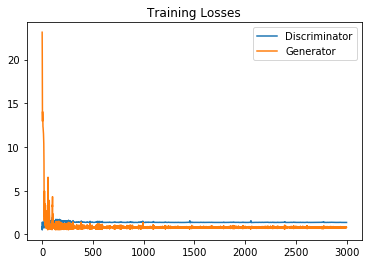

In [18]:
fig, ax = plt.subplots()
d_losses = np.array(d_losses)
g_losses = np.array(g_losses)
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.title("Training Losses")
plt.legend()

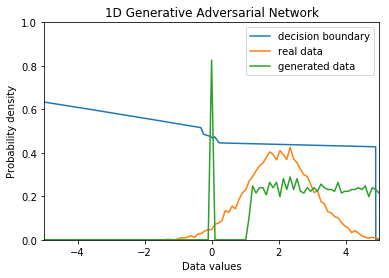

In [19]:
plot_distributions(samps, data_range)